In [1]:
#Import all libraries
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns

from matplotlib import pyplot as plt
from pathlib import Path as pth
from collections import Counter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from numpy.random import default_rng

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Emotion/")
!ls

 CREMA-D   RAVDESS  'TESS Toronto emotional speech set data'


In [4]:
print(type(os.getcwd()))

<class 'str'>


In [5]:
print(os.listdir())

['CREMA-D', 'TESS Toronto emotional speech set data', 'RAVDESS']


In [6]:
print(list((pth.cwd()).iterdir()))

[PosixPath('/content/drive/MyDrive/Colab Notebooks/Emotion/CREMA-D'), PosixPath('/content/drive/MyDrive/Colab Notebooks/Emotion/TESS Toronto emotional speech set data'), PosixPath('/content/drive/MyDrive/Colab Notebooks/Emotion/RAVDESS')]


In [7]:
currdir = os.getcwd()
ravdess = os.path.join(currdir, "RAVDESS/audio_speech_actors_01-24")
crema = os.path.join(currdir, "CREMA-D//AudioWAV")
tess = os.path.join(currdir, "TESS Toronto emotional speech set data//TESS Toronto emotional speech set data")
print(ravdess)
print(crema)
print(tess)
os.listdir(ravdess)

/content/drive/MyDrive/Colab Notebooks/Emotion/RAVDESS/audio_speech_actors_01-24
/content/drive/MyDrive/Colab Notebooks/Emotion/CREMA-D//AudioWAV
/content/drive/MyDrive/Colab Notebooks/Emotion/TESS Toronto emotional speech set data//TESS Toronto emotional speech set data


['Actor_13',
 'Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12']

## Ravdess Dataframe

Here is the filename identifiers as per the official RAVDESS website:
Modality (01 = full-AV, 02 = video-only, 03 = audio-only). Vocal channel (01 = speech, 02 = song). Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised). Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"). Repetition (01 = 1st repetition, 02 = 2nd repetition). Actor (01 to 24. Odd numbered actors are male, even numbered actors are female). So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02) Speech (01) Fearful (06) Normal intensity (01) Statement "dogs" (02) 1st Repetition (01) 12th Actor (12) - Female (as the actor ID number is even)

In [8]:
ravdess_directory_list = os.listdir(ravdess)
file_emotion = []
file_path = []
for actor_folder in ravdess_directory_list:
    audio_files = os.listdir(ravdess + "/" + actor_folder)
    for file in audio_files:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + "/" + actor_folder + '/' + file)

In [9]:
print("Number of Files in Ravdess:")
print(len(file_path))

Number of Files in Ravdess:
746


In [10]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

In [11]:
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
print("Ravdess Database:")
ravdess_df.head()

Ravdess Database:


Emotions                                               Path
0     fear  /content/drive/MyDrive/Colab Notebooks/Emotion...
1     calm  /content/drive/MyDrive/Colab Notebooks/Emotion...
2     calm  /content/drive/MyDrive/Colab Notebooks/Emotion...
3     calm  /content/drive/MyDrive/Colab Notebooks/Emotion...
4     fear  /content/drive/MyDrive/Colab Notebooks/Emotion...

## CREMA-D dataset

Content CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

'a' = 'anger' 'd' = 'disgust' 'f' = 'fear' 'h' = 'happiness' 'n' = 'neutral' 'sa' = 'sadness' 'su' = 'surprise

Filename labeling conventions The Actor id is a 4 digit number at the start of the file. Each subsequent identifier is separated by an underscore (_).

Actors spoke from a selection of 12 sentences (in parentheses is the three letter acronym used in the second part of the filename):

It's eleven o'clock (IEO). That is exactly what happened (TIE). I'm on my way to the meeting (IOM). I wonder what this is about (IWW). The airplane is almost full (TAI). Maybe tomorrow it will be cold (MTI). I would like a new alarm clock (IWL) I think I have a doctor's appointment (ITH). Don't forget a jacket (DFA). I think I've seen this before (ITS). The surface is slick (TSI). We'll stop in a couple of minutes (WSI). The sentences were presented using different emotion (in parentheses is the three letter code used in the third part of the filename):

Anger (ANG) Disgust (DIS) Fear (FEA) Happy/Joy (HAP) Neutral (NEU) Sad (SAD) and emotion level (in parentheses is the two letter code used in the fourth part of the filename):

Low (LO) Medium (MD) High (HI) Unspecified (XX) The suffix of the filename is based on the type of file, flv for flash video used for presentation of both the video only, and the audio-visual clips. mp3 is used for the audio files used for the audio-only presentation of the clips. wav is used for files used for computational audio processing.

Audio Files MP3 Audio files used for presentation to the Raters are stored in the AudioMP3 directory.

Note: The following files do not have correct audio based on their filename, but they are most likely what the raters heard. (Thank you ruanxiu520 for finding these and pointing them out.):

1076_MTI_NEU_XX.mp3 - very short, no audio (WAV file is fine) 1076_MTI_SAD_XX.mp3/wav - no audio, very short 1064_TIE_SAD_XX.mp3 - file has no duration 1064_IEO_DIS_MD.mp3 - this file is actually 1 minute long and has all emotional displays for It's Eleven O'clock. Processed Audio WAV Audio files converted from the original video into a format appropriate for computational audio processing are stored in the AudioWAV directory.

In [12]:
crema_directory_list = os.listdir(crema)

file_emotion = []
file_path = []
print("Nunber of Audio Files:")
print(len(crema_directory_list))

for file in crema_directory_list:
    file_path.append(crema + "/" + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

Nunber of Audio Files:
3113


In [13]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()

Emotions                                               Path
0      sad  /content/drive/MyDrive/Colab Notebooks/Emotion...
1    angry  /content/drive/MyDrive/Colab Notebooks/Emotion...
2  disgust  /content/drive/MyDrive/Colab Notebooks/Emotion...
3    happy  /content/drive/MyDrive/Colab Notebooks/Emotion...
4  neutral  /content/drive/MyDrive/Colab Notebooks/Emotion...

## TESS

Content There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [14]:
tess_directory_list = os.listdir(tess)

file_emotion = []
file_path = []

for actor_folder in tess_directory_list:
    audio_files = os.listdir(tess + "/" + actor_folder)
    for file in audio_files:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess + "/" + actor_folder + '/' + file)

print("Number of Audio Files in Tess Dataset: ")
print(len(file_emotion))

Number of Audio Files in Tess Dataset: 
2800


In [15]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
tess_df = pd.concat([emotion_df, path_df], axis=1)
tess_df.head()

Emotions                                               Path
0     fear  /content/drive/MyDrive/Colab Notebooks/Emotion...
1     fear  /content/drive/MyDrive/Colab Notebooks/Emotion...
2     fear  /content/drive/MyDrive/Colab Notebooks/Emotion...
3     fear  /content/drive/MyDrive/Colab Notebooks/Emotion...
4     fear  /content/drive/MyDrive/Colab Notebooks/Emotion...

In [16]:
# creating Dataframe using all the 3 dataframes we created so far.
emotion_dataset_path = pd.concat([ravdess_df, crema_df, tess_df], axis = 0)

emotion_dataset_path.to_csv("emotion_dataset_path.csv",index=False)
emotion_dataset_path.head()

Emotions                                               Path
0     fear  /content/drive/MyDrive/Colab Notebooks/Emotion...
1     calm  /content/drive/MyDrive/Colab Notebooks/Emotion...
2     calm  /content/drive/MyDrive/Colab Notebooks/Emotion...
3     calm  /content/drive/MyDrive/Colab Notebooks/Emotion...
4     fear  /content/drive/MyDrive/Colab Notebooks/Emotion...

In [17]:
emotion_dataset_path.Emotions

0       fear
1       calm
2       calm
3       calm
4       fear
        ... 
2795     sad
2796     sad
2797     sad
2798     sad
2799     sad
Name: Emotions, Length: 6659, dtype: object

In [18]:
emotion_dataset_path = pd.read_csv("emotion_dataset_path.csv")
print(type(emotion_dataset_path.Emotions[1]))
emotion_dataset_path.Emotions

<class 'str'>


0       fear
1       calm
2       calm
3       calm
4       fear
        ... 
6654     sad
6655     sad
6656     sad
6657     sad
6658     sad
Name: Emotions, Length: 6659, dtype: object

In [19]:
counter = Counter(emotion_dataset_path["Emotions"])
print(counter)

Counter({'angry': 1069, 'happy': 1067, 'sad': 1067, 'fear': 1066, 'disgust': 933, 'neutral': 921, 'surprise': 400, 'calm': 136})


<class 'pandas.core.series.Series'>
Emotions
angry       1069
happy       1067
sad         1067
fear        1066
disgust      933
neutral      921
surprise     400
calm         136
Name: count, dtype: int64


<ipython-input-20-a7104ef0181f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotions', data=emotion_dataset_path, palette='Spectral')  # 'Spectral' palette for diverse colors


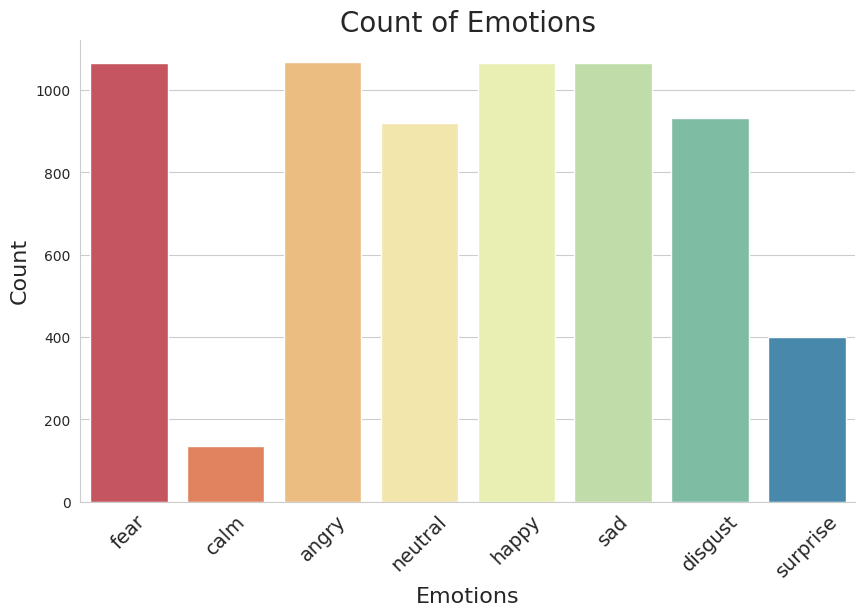

In [20]:
print(type(emotion_dataset_path.Emotions.value_counts()))
print(emotion_dataset_path.Emotions.value_counts())

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the count plot
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
sns.countplot(x='Emotions', data=emotion_dataset_path, palette='Spectral')  # 'Spectral' palette for diverse colors

# Customize the plot
plt.title('Count of Emotions', size=20)  # Increase title font size
plt.ylabel('Count', size=16)  # Increase y-axis label font size
plt.xlabel('Emotions', size=16)  # Increase x-axis label font size
plt.xticks(rotation=45, size=14)  # Rotate x-axis labels to prevent overlap
sns.despine(top=True, right=True, left=False, bottom=False)  # Remove top and right spines

plt.show()

Waveplots and spectrograms can be used to visualize audio signals in different ways.

Waveplots show the amplitude of the audio signal over time, indicating the volume levels at different points.

Spectrograms provide a visual way to examine the frequency spectrum of audio signals as it changes over time, offering insight into how various frequencies contribute to the audio signal at each moment.

In [21]:
def create_waveplot(data, sr, emotion_name):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion_name), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel('Time (s)', fontsize=12)  # Set x-axis label and font size
    plt.ylabel('Amplitude', fontsize=12)  # Set y-axis label and font size
    plt.show()

def create_spectrogram(data, sr, emotion_name):
    stft_matrix = librosa.stft(data)
    print("In Function:")
    stft_matrix_db = librosa.amplitude_to_db(abs(stft_matrix))

    # First spectrogram on a linear scale
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion on linear scale'.format(emotion_name), size=15)
    librosa.display.specshow(stft_matrix_db, sr=sr, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=12)  # Set x-axis label and font size
    plt.ylabel('Frequency (Hz)', fontsize=12)  # Set y-axis label and font size

    # Second spectrogram on a log scale
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion on a log scale'.format(emotion_name), size=15)
    librosa.display.specshow(stft_matrix_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=12)  # Set x-axis label and font size
    plt.ylabel('Frequency (Hz)', fontsize=12)  # Set y-axis label and font size
    plt.show()

[ 5.0236649e-06  8.0099098e-06  4.3907305e-05 ... -1.6796748e-05
 -1.6270407e-05  0.0000000e+00]
(107418,)
22050


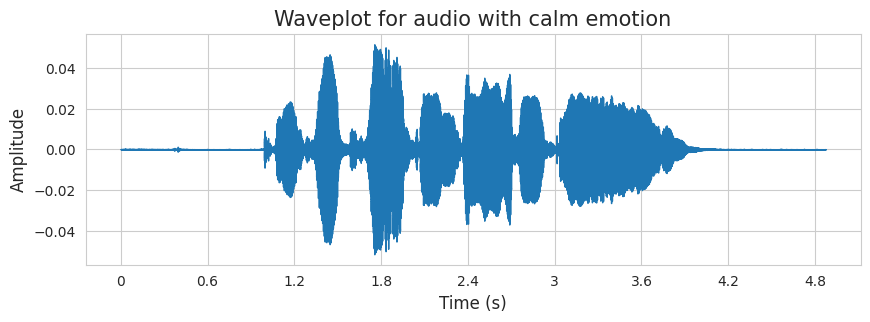

In Function:


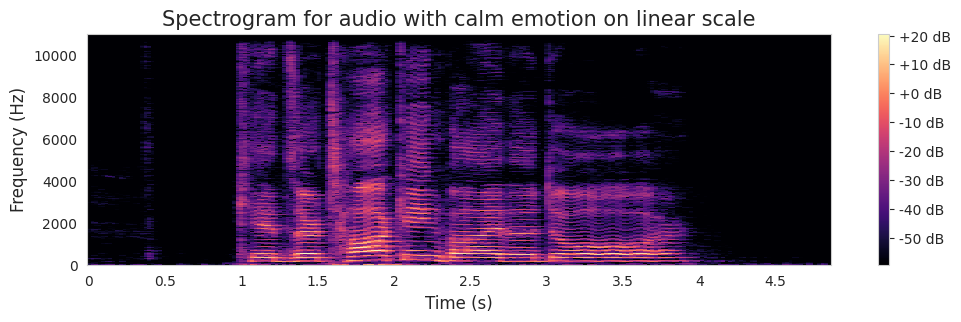

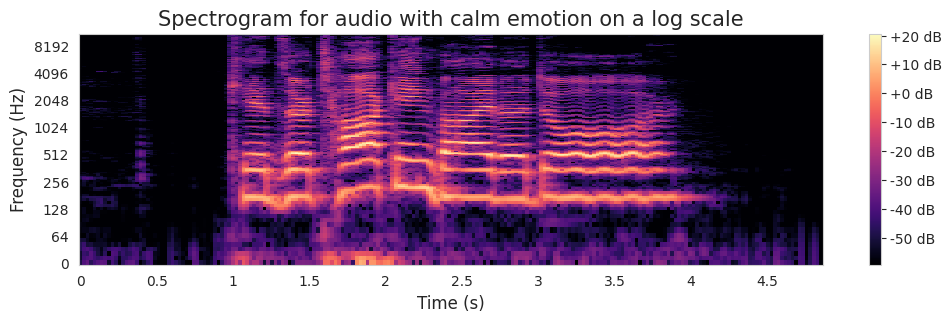

In [22]:
emotion='calm'
path = np.array(emotion_dataset_path.Path[emotion_dataset_path.Emotions==emotion])[1]
#print(path)
data, sampling_rate = librosa.load(path)
print(data)
print(data.shape)
print(sampling_rate)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

[ 8.4555140e-06 -8.1092345e-05 -1.1118640e-04 ... -2.3548664e-04
 -2.2632537e-04  0.0000000e+00]
(42655,)
22050


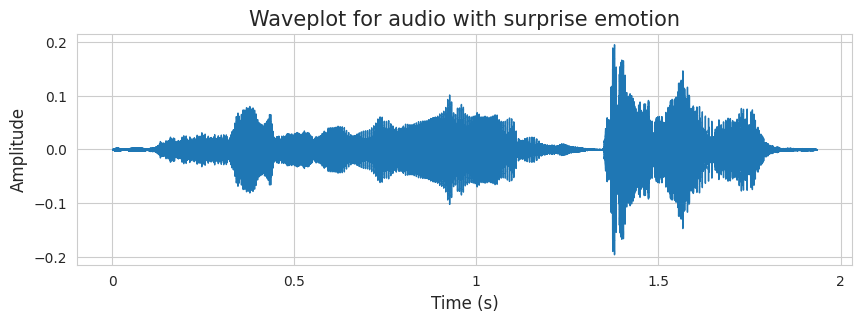

In Function:


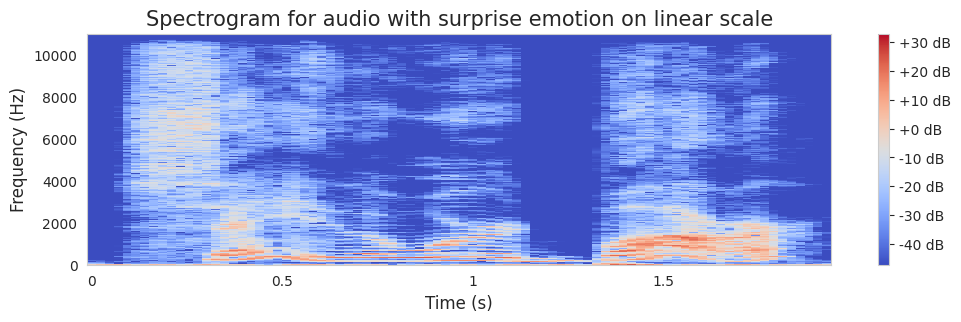

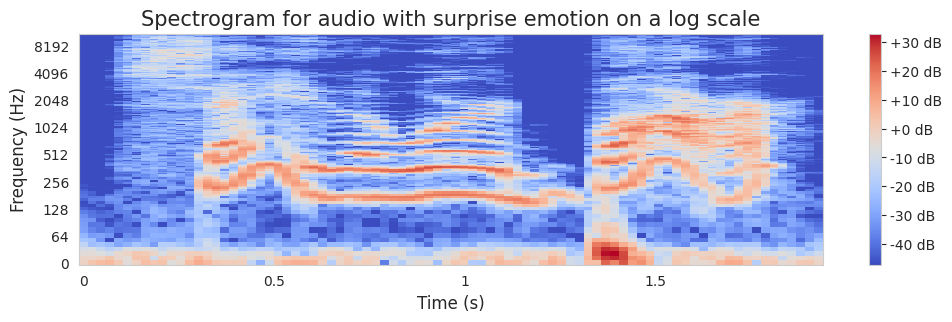

In [23]:
emotion='surprise'
path = np.array(emotion_dataset_path.Path[emotion_dataset_path.Emotions==emotion])[1]
#print(path)
data, sampling_rate = librosa.load(path)
print(data)
print(data.shape)
print(sampling_rate)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

[ 1.3311329e-05 -2.2022277e-08 -6.2588242e-08 ... -7.5179763e-05
 -6.6902408e-05 -6.2592058e-05]
(103003,)
22050


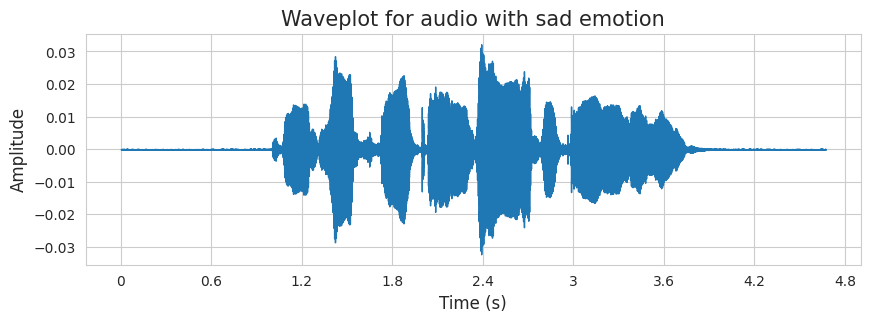

In Function:


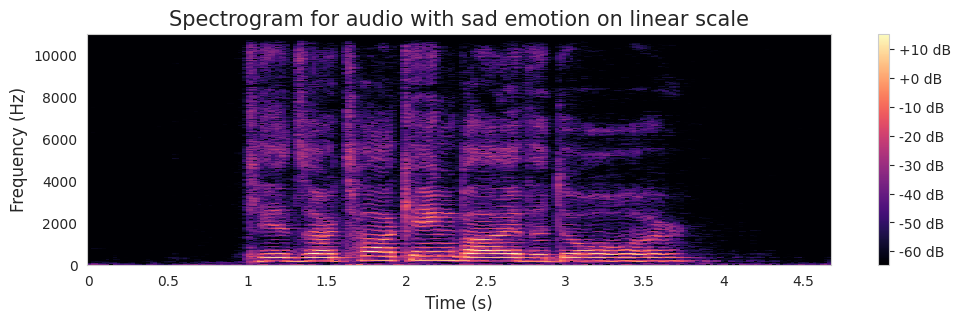

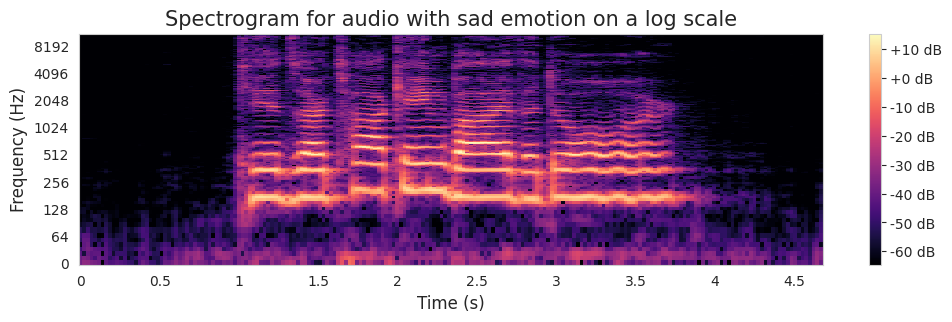

In [24]:
emotion='sad'
path = np.array(emotion_dataset_path.Path[emotion_dataset_path.Emotions==emotion])[1]
#print(path)
data, sampling_rate = librosa.load(path)
print(data)
print(data.shape)
print(sampling_rate)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

[ 1.6923037e-12  5.2065215e-13 -1.0864811e-12 ...  3.1502303e-05
  1.8884120e-05  6.7834981e-06]
(97117,)
22050


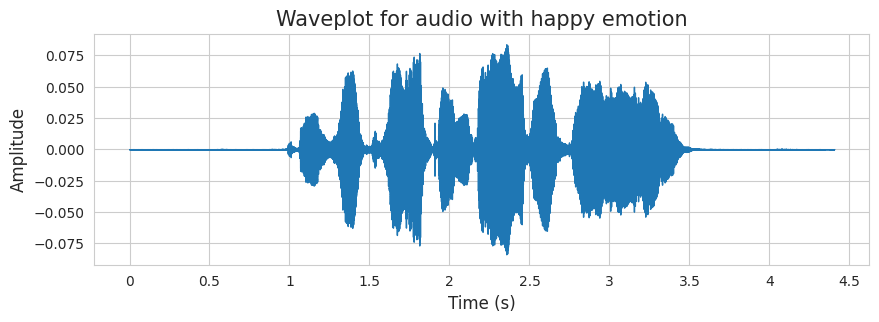

In Function:


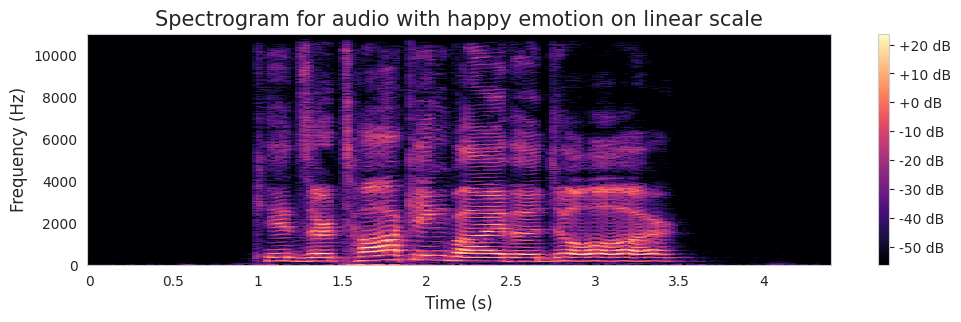

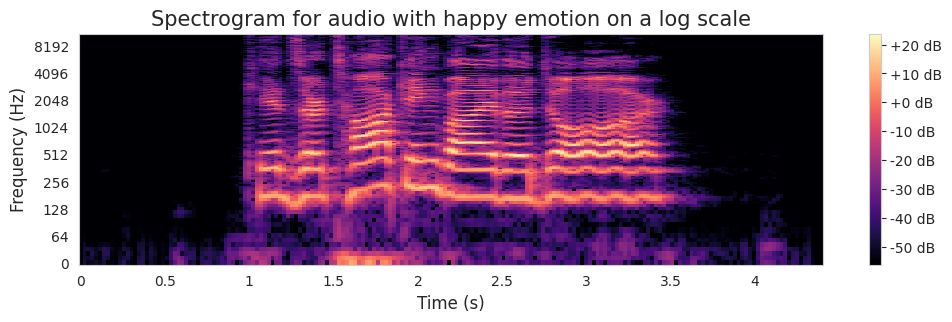

In [25]:
emotion='happy'
path = np.array(emotion_dataset_path.Path[emotion_dataset_path.Emotions==emotion])[1]
#print(path)
data, sampling_rate = librosa.load(path)
print(data)
print(data.shape)
print(sampling_rate)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

Data augmentation involves generating new synthetic samples by introducing minor variations to the original training dataset. For audio data, this can include techniques like injecting noise, shifting time, altering pitch and speed, with the goal of making the model more robust to such variations and improving its generalization capability. It's crucial that these modifications do not change the original label of the training sample. In the context of image data, augmentation might involve operations such as shifting, zooming, or rotating the images. Initially, we should identify which augmentation methods are most effective for our specific dataset.

In [26]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    x = np.roll(data, shift_range)
    return x

def pitch(data, sampling_rate, pitch_factor=0.7):
    x = librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)
    return x

path = np.array(emotion_dataset_path.Path)[1]
print(path)
data, sample_rate = librosa.load(path)
print(data)
print(type(data))
print(data.shape)
print(sampling_rate)

/content/drive/MyDrive/Colab Notebooks/Emotion/RAVDESS/audio_speech_actors_01-24/Actor_13/03-02-02-02-01-01-13.wav
[2.1528254e-05 9.2966347e-06 2.2119504e-05 ... 8.4615429e-05 8.4011459e-05
 5.4930213e-05]
<class 'numpy.ndarray'>
(116246,)
22050


In [27]:
rng = default_rng()
vals = rng.uniform()
more_vals = rng.uniform()
print("*"*50)
print("Vals: {}".format(vals))
print("More_Vals: {}".format(more_vals))
print("*"*50)
# instead of this (legacy version)
from numpy import random
vals = random.uniform()
more_vals = random.uniform()
print("*"*50)
print("Vals: {}".format(vals))
print("More_Vals: {}".format(more_vals))
print("*"*50)

**************************************************
Vals: 0.2562134473754776
More_Vals: 0.24829431828840376
**************************************************
**************************************************
Vals: 0.2968667717657206
More_Vals: 0.18802846281463892
**************************************************


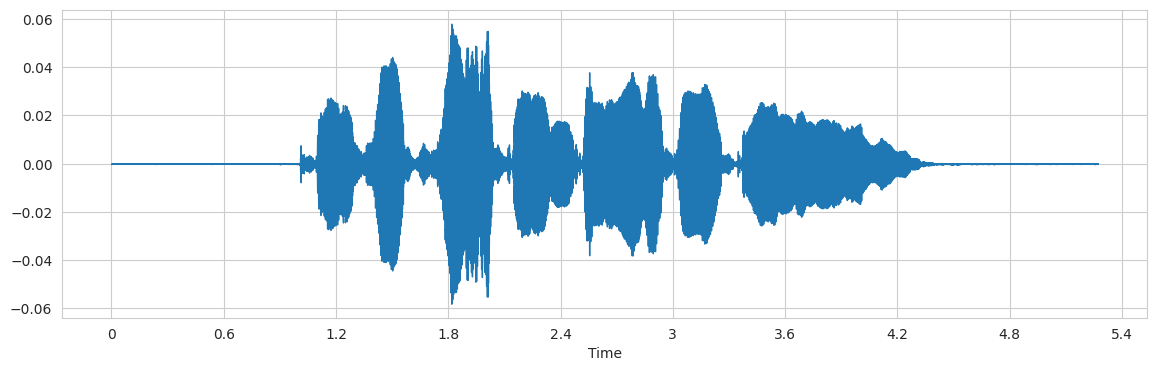

In [28]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

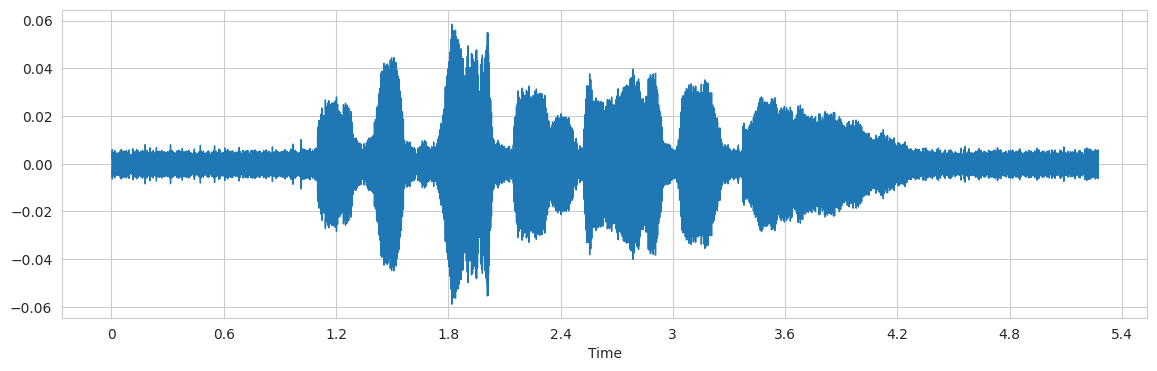

In [29]:
# Adding noise
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Stretched Data: 
[2.1415824e-05 9.2078790e-06 2.1833108e-05 ... 1.4524630e-05 2.0464357e-05
 2.1232439e-05]


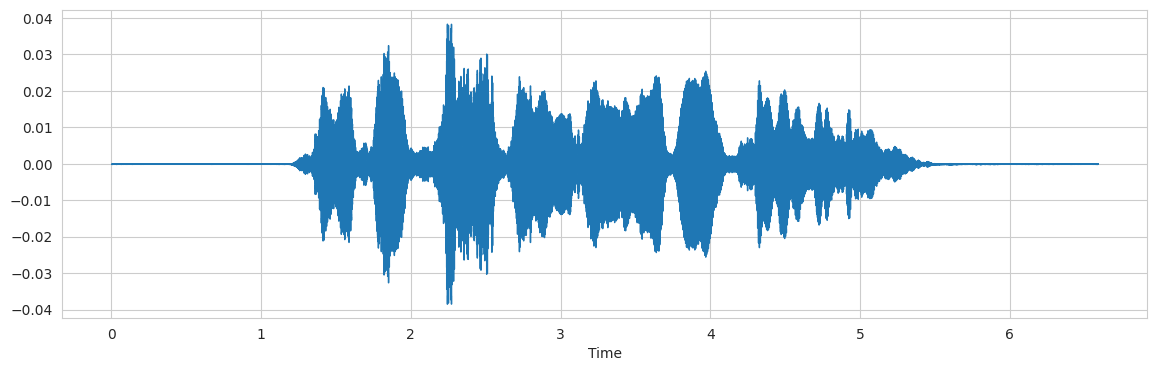

In [30]:
# Stretching
x = stretch(data)
print("Stretched Data: ")
print(x)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

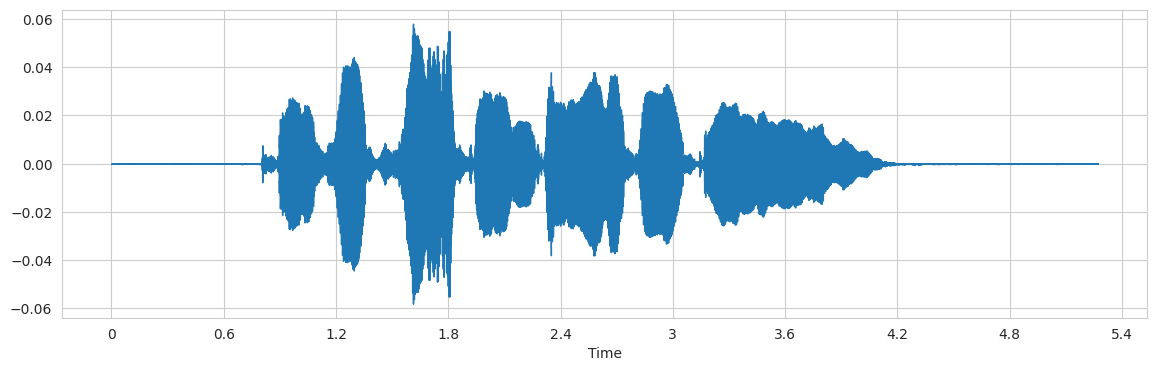

In [31]:
# Shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

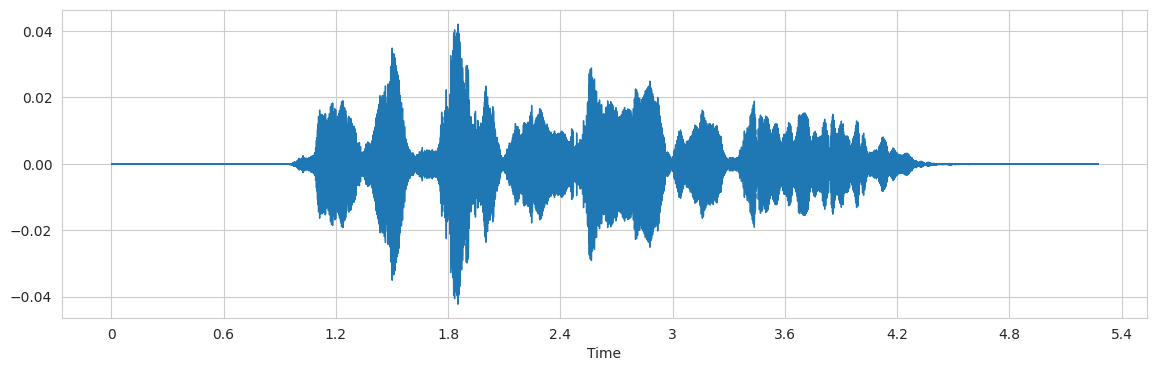

In [32]:
# Pitch
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [33]:
def extract_features(data, type_data):

    ############################################################################
    # ZCR
    result = np.array([])
    x = librosa.feature.zero_crossing_rate(y=data)
    zcr = np.mean(x.T, axis=0)
    result = np.hstack((result, zcr))
    ############################################################################

    ############################################################################
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    x = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    x_T = librosa.feature.chroma_stft(S=stft, sr=sample_rate).T
    chroma_stft = np.mean(x_T, axis=0)
    result = np.hstack((result, chroma_stft))
    ############################################################################

    ############################################################################
    # MFCC
    x = librosa.feature.mfcc(y=data, sr=sample_rate)
    mfcc = np.mean(x.T, axis=0)
    result = np.hstack((result, mfcc))
    ############################################################################

    ############################################################################
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    ############################################################################

    ############################################################################
    # Spectral Centroid
    sp_cent = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, sp_cent)) # stacking horizontally
    ############################################################################

    ############################################################################
    # Spectral Bandwidth
    sp_band = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, p=2).T, axis = 0)
    ############################################################################

    ############################################################################
    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz))
    ############################################################################

    ############################################################################
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    ############################################################################

    return result

In [34]:
def get_features(path):
    # Initialize the result array
    result = np.array([])

    # Load the audio file with specified duration and offset
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Ensure the data length is at least 1024 to avoid 'n_fft too small' warning
    if len(data) < 1024:
        data = np.pad(data, (0, max(0, 1024 - len(data))), 'constant')

    # Extract features without augmentation
    res1 = extract_features(data, type_data="Normal")
    result = np.array([res1])  # Ensure the result is two-dimensional

    # Data with noise augmentation
    noise_data = noise(data)
    res2 = extract_features(noise_data, type_data="Noisy")
    result = np.vstack((result, [res2]))  # Stack vertically

    # Data with stretching and pitching augmentation
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, type_data="Stretched and Pitched")
    result = np.vstack((result, [res3]))  # Stack vertically

    return result


In [35]:
result = np.array([])

print("Spectral Bandwidth: ")
print(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, p=2).shape)
print(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, p=2))
print("Spectral Bandwidth Mean: ")
print(np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, p=2).T, axis = 0).shape)
print(np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, p=2).T, axis = 0))
#print(data.shape)

Spectral Bandwidth: 
(1, 228)
[[3343.324606   3425.40108731 3374.64987483 3355.47262823 3376.85530927
  3414.50806077 3375.06848803 3394.22855134 3322.49572599 3366.05795533
  3409.79995266 3382.27311798 3334.45971302 3306.78617443 3317.84563736
  3386.49470546 3422.66962378 3124.71403074 3196.0279216  3288.41292382
  3313.90813623 3189.40628143 3438.86991356 3467.95744842 3387.0838365
  3280.335754   3313.03695004 3382.35276552 3459.44279365 3462.4226269
  3364.1213967  3384.08774812 3419.00416479 3365.5034676  3306.71158991
  3295.31196908 3343.0628974  3296.72338605 3218.058051   3163.06533542
  3210.14491947 3251.52341096 2933.59320923 2852.10018307 2782.35538955
  2699.65863401 2872.72919031 2598.00392892 2272.86090827 2134.46742948
  2200.8266566  2163.43415141 1877.57010926 1835.67790141 1941.3608076
  1924.27668409 1833.53686971 2524.06916812 3624.363195   3779.58169898
  3372.32200447 2233.23213189 1766.77734571 1598.24612362 1488.86744544
  1485.63390061 1557.36419757 1610.56

In [ ]:
X, y = [], []
for path, emotion in zip(emotion_dataset_path.Path, emotion_dataset_path.Emotions):
    feature = get_features(path)
    for normal_plus_additional_features in feature:
        X.append(normal_plus_additional_features)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        y.append(emotion)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=862
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=794
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=992
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=621
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=777
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=817
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: 

In [ ]:
print("Input Variable: ")
print(len(X))
#print(X)
print("Output Variable: ")
print(len(y))
#print(y)
print(emotion_dataset_path.Path.shape)

In [ ]:
Features_db = pd.DataFrame(X)
Features_db['labels'] = y
Features_db.to_csv('Features_Database_Extended.csv', index=False)
Features_db.head()

In [ ]:
Features_db = pd.read_csv('Features_Database_Extended.csv')
Features_db.head()

In [ ]:
X = Features_db.iloc[: ,:-1].values
y = Features_db['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [ ]:
print(y.shape)
asd = y.reshape(-1,1)
print(asd.shape)
print(encoder)
zxc = encoder.fit_transform(asd)
print(zxc)

In [ ]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train)

In [ ]:
X_train[0][0]

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
#model.add(Dense(units=8, activation='relu'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
#model.compile(optimizer = 'adam' , loss = tf.nn.ctc_loss(labels=y_train,logits = X_train) , metrics = ['accuracy'])
model.summary()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.00000000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=150, validation_data=(X_test, y_test), callbacks=[rlrp])

In [ ]:
!mkdir saved_models1
model.save('saved_models1/ser_SmallCNN_ExtendedDataset_model')

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")


fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']
epochs = [i for i in range(len(train_loss))]
# epochs = range(50)
print(epochs)

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(X_test)
print(pred_test)

y_pred = encoder.inverse_transform(pred_test)
print(y_pred)
print(y_pred.shape)
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(100)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))

In [ ]:
model=Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = [tf.keras.metrics.CategoricalCrossentropy(), 'accuracy'])

model.summary()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.00000000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=150, validation_data=(X_test, y_test), callbacks=[rlrp])

In [ ]:
!mkdir saved_model_Long_CNN
model.save('saved_model_Long_CNN/ser_LongCNN_model')

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")


fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']
epochs = [i for i in range(len(train_loss))]
# epochs = range(50)
print(epochs)

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# predicting on test data.
pred_test = model.predict(X_test)
print(pred_test)

y_pred = encoder.inverse_transform(pred_test)
print(y_pred)
print(y_pred.shape)
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(100)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))

In [ ]:
model=Sequential()
#
model.add(LSTM(units=256, activation='tanh',  input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(keras.layers.Dropout(rate=0.3))
#
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(keras.layers.Dropout(rate=0.3))

model.add(LSTM(units=64, activation='tanh'))
model.add(keras.layers.Dropout(rate=0.3))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) , loss = 'categorical_crossentropy' ,
              metrics = ['accuracy'])

model.summary()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=150, validation_data=(X_test, y_test), callbacks=[rlrp])

In [ ]:
!mkdir saved_model_LSTM
model.save('saved_model_LSTM/ser_LSTM_model')

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(len(train_loss))]
# epochs = range(50)
print(epochs)
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test.shape

In [ ]:
y_pred = encoder.inverse_transform(pred_test)
print(y_pred)
print(y_pred.shape)

In [ ]:
y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

In [ ]:
df.head(100)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))